# Import Modules

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install mahotas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 39.5 MB/s eta 0:00:00


In [3]:
import cv2
import numpy as np
import pandas as pd

from google.colab.patches import cv2_imshow

%matplotlib inline
from matplotlib import pyplot as plt
import pylab
from scipy.spatial.distance import mahalanobis
from itertools import combinations
from tqdm import tqdm

from skimage.measure import regionprops
import mahotas #for center of mass

import os
import sys


pylab.rcParams['figure.figsize'] = (10.0, 8.0) # this controls figure size in the notebook

In [4]:
PATH_TRAIN = PATH_TO_IMAGE = "/content/drive/My Drive/CS 419/HW3/train"
PATH_TEST = PATH_TO_IMAGE = "/content/drive/My Drive/CS 419/HW3/test"

In [5]:
#os.listdir(PATH_TRAIN)

# Setup

In [6]:
def cname(s):
  return s[: s.find('-')]

In [7]:
class_dir = {}

for i in os.listdir(PATH_TRAIN):

  class_name = cname(i)

  if class_name not in class_dir:
    class_dir[class_name] = 1

classes = list(class_dir.keys())

In [8]:
train_images = {}
test_images = {}

for i in os.listdir(PATH_TRAIN):
  gray = cv2.imread(os.path.join(PATH_TRAIN, i), cv2.IMREAD_GRAYSCALE)
  binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
  train_images[i] = binary[1]

for i in os.listdir(PATH_TEST):
  gray = cv2.imread(os.path.join(PATH_TEST, i), cv2.IMREAD_GRAYSCALE)
  binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
  test_images[i] = binary[1]

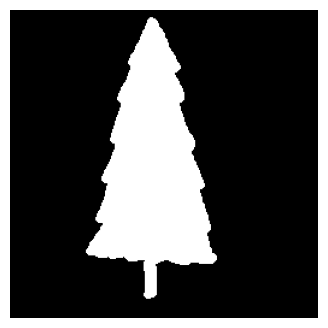

In [9]:
plt.figure(figsize=(4,4))
plt.imshow(train_images['tree-5.png'], cmap='gray')
plt.axis('off')
# Show the plot
plt.show()

# Distance

In [10]:
def euclidean(v1, v2):
  return np.linalg.norm(v1 - v2)

def manhattan(v1, v2):
  return np.sum(np.abs(v1 - v2))

def chi_square_dist(v1, v2):
  return 0.5 * np.sum((v1 - v2)**2 / (v1 + v2))

def mahal(v1, v2):
  transpose_vectors = np.array([v1, v2]).T
  cov = np.cov(transpose_vectors)
  cov += 1e-5 * np.eye(cov.shape[0])
  return mahalanobis(v1, v2, np.linalg.inv(cov))

# Dataset

In [11]:
#image struct
class Image():

  def __init__(self, image, cname, feature):
    self.image = image
    self.class_name = cname
    self.feature_vector = feature
    self.basics = regionprops(self.image)[0]
    self.basic_descriptors = {
        'area': self.basics.area,
        'perimeter': self.basics.perimeter,
        'convexity': self.basics.solidity,
        'eccentricity': self.basics.eccentricity,
        'circularity': (self.basics.perimeter)**2/self.basics.area,
        'rectangularity': self.basics.area / self.basics.area_bbox
    }
    self.mock = np.array([self.basic_descriptors['area'], self.basic_descriptors['perimeter'], self.basic_descriptors['circularity']])
    self.shape_histogram = {}
    self.fourier_descriptor = {}

    m = cv2.moments(self.image)
    self.hu_moments = np.append(cv2.HuMoments(m), np.array(m['nu11'] * ( (m['nu30'] + m['nu12'])**2  -  (m['nu03'] + m['nu21'])**2 )  -  ((m['nu20'] - m['nu02']) * (m['nu30'] + m['nu12']) * (m['nu03'] + m['nu21']))))


train_dataset = list()
test_dataset = list()

In [12]:
for key, value in train_images.items():
  class_name = cname(key)
  image = Image(value, class_name, None)
  train_dataset.append(image)

In [13]:
for key, value in test_images.items():
  class_name = cname(key)
  image = Image(value, class_name, None)
  test_dataset.append(image)

In [14]:
for prop in train_dataset[0].basic_descriptors:
  print(prop)

area
perimeter
convexity
eccentricity
circularity
rectangularity


In [15]:
train_dataset[0].basic_descriptors['rectangularity']

0.7541491963661775

test whether mahalanobis works or not

In [16]:
for i in range(700):
  mahal(train_dataset[i].mock, test_dataset[i].mock)

#Shape Descriptors

With regionprops we have all the basic descriptors and moment descriptors. Now we also have to calculate shape histogram and fourier

In [17]:
class ShapeDescriptors():

  def __init__(self, train_dataset, test_dataset):
    self.train = train_dataset
    self.test = test_dataset

  #Fourier Descriptor

  def fd(self, data, nd):
    for img in data:
      contours, _ = cv2.findContours(img.image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      contours = max(contours, key=cv2.contourArea)
      z = []
      for point in contours:
        z_m = complex(int(point[0][0]), int(point[0][1]))
        z.append(z_m)

      # print(len(contours[0]))
      if nd > len(contours):
        #print(img.class_name)
        #print('You entered coef num bigger than boundary pixel number. It is set to boundary pixel numbers.')
        z = z[:len(contours)]
      else:
        z = z[:nd]

      z_fft = np.fft.fft(z)

      img.fourier_descriptor[nd] = np.abs(z_fft)

  def fourier_descriptor(self, n):
    self.fd(self.train, n)
    self.fd(self.test, n)


  #shape histogram
  def sh(self, data, n):
    for img in data:
        com = mahotas.center_of_mass(img.image)
        center_x = com[0]
        center_y = com[1]

        #find the most distant pixel
        contours, _ = cv2.findContours(img.image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = max(contours, key=cv2.contourArea)
        distances = []
        for point in contours:
          x,y = point[0]
          distance = np.sqrt((center_x - x)**2 + (center_y - y)**2)
          distances.append(distance)

        radii = np.linspace(0, distances[np.argmax(distances)], n)

        area_in_radii = []
        for i in range(1, len(radii)):
          radius = radii[i] - radii[0]
          mask = np.zeros_like(img.image)
          cv2.circle(mask, (int(center_x), int(center_y)), int(radius), 255, thickness=-1)
          b = img.image & mask

          count = np.count_nonzero(b)
          area_in_radii.append(count)

        for i in range(1, len(area_in_radii)):
          area_in_radii[i] = area_in_radii[i] - area_in_radii[i-1]


        img.shape_histogram[n-1] = np.array(area_in_radii)

  def shape_histogram(self, n):
    self.sh(self.train, n)
    self.sh(self.test, n)

  def clean_sh(self):
    for i in self.train:
      i.shape_histogram = {}
    for i in self.test:
      i.shape_histogram = {}

  def clean_fd(self):
    for i in self.train:
      i.fourier_descriptor = {}
    for i in self.test:
      i.fourier_descriptor = {}


In [18]:
Descriptor = ShapeDescriptors(train_dataset, test_dataset)

# Basic Shape Descriptors

In [19]:
train_dataset[0].basic_descriptors['eccentricity']

0.23131262147906737

# Shape Histogram

In [20]:
shape_histogram_counts = [4, 6, 11, 21, 51]

for i in shape_histogram_counts:
  Descriptor.shape_histogram(i) # n - 1 circles

In [21]:
# train_dataset[0].shape_histogram

# Fourier Transform

In [22]:
fourier_descriptor_counts = [3, 5, 10, 40, 60, 80]

for i in fourier_descriptor_counts:
  Descriptor.fourier_descriptor(i) # n - 1 circles

In [23]:
train_dataset[10].fourier_descriptor[3]

array([728.45384205,   2.12976487,   3.38586793])

In [24]:
mahal(train_dataset[0].fourier_descriptor[3], test_dataset[0].fourier_descriptor[3])

1.4142135533489881

# Moment

In [25]:
def hu_moments(i):
  m = cv2.moments(i)
  return np.append(cv2.HuMoments(m), np.array(m['nu11'] * ( (m['nu30'] + m['nu12'])**2  -  (m['nu03'] + m['nu21'])**2 )  -  ((m['nu20'] - m['nu02']) * (m['nu30'] + m['nu12']) * (m['nu03'] + m['nu21']))))

# Combinations

In [ ]:
basic_descriptors = ['area', 'perimeter', 'circularity', 'eccentricity', 'rectangularity', 'convexity']

def combinate(lst):
  # Find all combinations
  comb = []
  for r in range(2, len(lst) + 1):
    comb.extend(combinations(lst, r))

  return comb


combs = combinate(basic_descriptors)

In [ ]:
len(combs)

57

#Experimentation

## Experimentations with all different combinations of basic descriptors length >= 2

In [83]:
combs =[
 ('eccentricity', 'convexity'),
 ('eccentricity', 'rectangularity'),
 ('area', 'rectangularity'),
 ('eccentricity', 'rectangularity', 'convexity'),
 ('perimeter', 'eccentricity', 'rectangularity'),
 ('perimeter', 'circularity', 'eccentricity', 'rectangularity'),
 ('area', 'circularity', 'eccentricity', 'rectangularity'),
 ('perimeter', 'circularity', 'eccentricity', 'rectangularity', 'convexity'),
 ('area', 'circularity', 'eccentricity', 'rectangularity', 'convexity'),
 ('area', 'perimeter', 'circularity', 'eccentricity', 'rectangularity', 'convexity')
 ]

In [84]:
performance = {}
count = 0
for combination in tqdm(combs, desc="Processing Combinations"):
  euc_acc = 0
  man_acc = 0
  chi_acc = 0
  mah_acc = 0
  for te in test_dataset:
    cname = te.class_name
    euc_class = []
    man_class = []
    chi_class = []
    mah_class = []
    for tr in train_dataset:
      train_descriptor = []
      test_descriptor = []

      train_descriptor = np.array([tr.basic_descriptors[c] for c in combination])
      test_descriptor = np.array([te.basic_descriptors[c] for c in combination])

      euc = euclidean(train_descriptor, test_descriptor)
      man = manhattan(train_descriptor, test_descriptor)
      chi = chi_square_dist(train_descriptor, test_descriptor)
      mah = mahal(train_descriptor, test_descriptor)

      euc_class.append((euc, tr.class_name))
      man_class.append((man, tr.class_name))
      chi_class.append((chi, tr.class_name))
      mah_class.append((mah, tr.class_name))

    min_euc = min(euc_class, key=lambda x: x[0])
    min_man = min(man_class, key=lambda x: x[0])
    min_chi = min(chi_class, key=lambda x: x[0])
    min_mah = min(mah_class, key=lambda x: x[0])

    if min_euc[1] == cname:
      euc_acc += 1

    if min_man[1] == cname:
      man_acc += 1

    if min_chi[1] == cname:
      chi_acc += 1

    if min_mah[1] == cname:
      mah_acc += 1


  performance[combination] = {
      'euc': euc_acc/700,
      'man': man_acc/700,
      'chi': chi_acc/700,
      'mah': mah_acc/700
  }

Processing Combinations: 100%|██████████| 10/10 [22:22<00:00, 134.21s/it]


In [85]:
count = 0
for k in performance.keys():
  count += 1
print(count)

10


In [86]:
for key, value in performance.items():
  euc = value['euc']
  man = value['man']
  chi = value['chi']
  mah = value['mah']
  print(f'Basic Descriptor Combinations: {key}, euclidean performance: {euc}, manhattan performance: {man}, chi square performance: {chi}, mahalanobis performance: {mah} ')

Basic Descriptor Combinations: ('eccentricity', 'convexity'), euclidean performance: 0.36714285714285716, manhattan performance: 0.37, chi square performance: 0.3585714285714286, mahalanobis performance: 0.36714285714285716 
Basic Descriptor Combinations: ('eccentricity', 'rectangularity'), euclidean performance: 0.35, manhattan performance: 0.3557142857142857, chi square performance: 0.3457142857142857, mahalanobis performance: 0.35 
Basic Descriptor Combinations: ('area', 'rectangularity'), euclidean performance: 0.18428571428571427, manhattan performance: 0.18428571428571427, chi square performance: 0.19714285714285715, mahalanobis performance: 0.18285714285714286 
Basic Descriptor Combinations: ('eccentricity', 'rectangularity', 'convexity'), euclidean performance: 0.4857142857142857, manhattan performance: 0.47714285714285715, chi square performance: 0.4757142857142857, mahalanobis performance: 0.4857142857142857 
Basic Descriptor Combinations: ('perimeter', 'eccentricity', 'recta

## Shape Histogram

In [26]:
Descriptor.clean_sh()
shape_histogram_counts = [4, 6, 11, 21, 51]

for i in shape_histogram_counts:
  Descriptor.shape_histogram(i) # n - 1 circles

In [27]:
train_dataset[0].shape_histogram
test_dataset[0].shape_histogram

{3: array([ 6921, 16127, 17097]),
 5: array([ 2453,  7620, 11851, 17371, 15853]),
 10: array([  613,  1840,  3685,  6388,  8193, 11278, 13509, 15713, 16054,
        17170]),
 20: array([  149,   464,   909,  1544,  2309,  3216,  4629,  5444,  6839,
         7742,  9254, 10217, 11736, 13051, 14051, 15171, 15486, 16281,
        16389, 16835]),
 50: array([   13,    68,   129,   248,   365,   536,   721,   796,  1165,
         1288,  1713,  1912,  2381,  2644,  2881,  3480,  3733,  4440,
         4696,  5377,  5631,  6013,  6604,  6975,  7606,  8002,  8634,
         9047,  9345, 10126, 10401, 11201, 11477, 12257, 12530, 12930,
        13519, 13900, 14445, 14777, 15140, 15343, 15482, 15835, 15932,
        16256, 16307, 16572, 16548, 16676])}

In [28]:
shape_histogram_performance = {}
count = 0
for combination in tqdm(shape_histogram_counts, desc="Processing Combinations"):
  euc_acc = 0
  man_acc = 0
  chi_acc = 0
  mah_acc = 0
  for te in test_dataset:
    cname = te.class_name
    euc_class = []
    man_class = []
    chi_class = []
    mah_class = []
    for tr in train_dataset:
      train_descriptor = []
      test_descriptor = []

      train_descriptor = tr.shape_histogram[combination-1]
      test_descriptor = te.shape_histogram[combination-1]

      euc = euclidean(train_descriptor, test_descriptor)
      man = manhattan(train_descriptor, test_descriptor)
      chi = chi_square_dist(train_descriptor, test_descriptor)
      mah = mahal(train_descriptor, test_descriptor)

      euc_class.append((euc, tr.class_name))
      man_class.append((man, tr.class_name))
      chi_class.append((chi, tr.class_name))
      mah_class.append((mah, tr.class_name))

    min_euc = min(euc_class, key=lambda x: x[0])
    min_man = min(man_class, key=lambda x: x[0])
    min_chi = min(chi_class, key=lambda x: x[0])
    min_mah = min(mah_class, key=lambda x: x[0])

    if min_euc[1] == cname:
      euc_acc += 1

    if min_man[1] == cname:
      man_acc += 1

    if min_chi[1] == cname:
      chi_acc += 1

    if min_mah[1] == cname:
      mah_acc += 1


  shape_histogram_performance[combination] = {
      'euc': euc_acc/700,
      'man': man_acc/700,
      'chi': chi_acc/700,
      'mah': mah_acc/700
  }

Processing Combinations:   0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-10-eceabc8b4a33>:8: RuntimeWarning: invalid value encountered in divide
  return 0.5 * np.sum((v1 - v2)**2 / (v1 + v2))
Processing Combinations:  60%|██████    | 3/5 [05:41<03:48, 114.44s/it]/usr/local/lib/python3.10/dist-packages/scipy/spatial/distance.py:1023: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)
Processing Combinations: 100%|██████████| 5/5 [11:27<00:00, 137.49s/it]


In [29]:
for key, value in shape_histogram_performance.items():
  euc = value['euc']
  man = value['man']
  chi = value['chi']
  mah = value['mah']
  print(f'Shape Histogram Size: {key-1}, euclidean performance: {euc}, manhattan performance: {man}, chi square performance: {chi}, mahalanobis performance: {mah} ')

Shape Histogram Size: 3, euclidean performance: 0.43142857142857144, manhattan performance: 0.42714285714285716, chi square performance: 0.39571428571428574, mahalanobis performance: 0.014285714285714285 
Shape Histogram Size: 5, euclidean performance: 0.46, manhattan performance: 0.45571428571428574, chi square performance: 0.37714285714285717, mahalanobis performance: 0.012857142857142857 
Shape Histogram Size: 10, euclidean performance: 0.4614285714285714, manhattan performance: 0.4514285714285714, chi square performance: 0.3442857142857143, mahalanobis performance: 0.014285714285714285 
Shape Histogram Size: 20, euclidean performance: 0.42428571428571427, manhattan performance: 0.41714285714285715, chi square performance: 0.30857142857142855, mahalanobis performance: 0.011428571428571429 
Shape Histogram Size: 50, euclidean performance: 0.4342857142857143, manhattan performance: 0.4328571428571429, chi square performance: 0.2985714285714286, mahalanobis performance: 0.0114285714285

## Fourier

In [118]:
Descriptor.clean_fd()
fourier_descriptor_counts = [3, 5, 10, 40, 60, 80]

for i in fourier_descriptor_counts:
  Descriptor.fourier_descriptor(i) # n - 1 circles

In [119]:
test_dataset[0].fourier_descriptor

{3: array([278.82073094,   5.93425567,   8.76268279]),
 5: array([467.74031257,  11.21051388,   6.30280881,   7.62302581,
         15.50769026]),
 10: array([954.18446854,  23.28862182,  16.49535461,  12.39699328,
          8.5973314 ,   6.32455532,  10.50434803,  15.89264622,
         21.80935216,  32.73191787]),
 40: array([4559.25103498,  414.01326176,  238.82486481,  156.95519557,
         109.74715473,   79.48639467,   46.93145693,   50.967367  ,
          56.09483209,   51.28210624,   51.10772936,   39.91711934,
          35.13383957,   35.73140394,   35.66903253,   34.01060551,
          34.60422392,   25.86974061,   26.31830115,   26.28300709,
          37.01351105,   23.91612607,   32.26165404,   26.0552847 ,
          31.3850399 ,   36.41308916,   35.16746613,   38.86253925,
          38.76882554,   42.62206505,   49.39635614,   52.20604228,
          58.6591576 ,   69.20914369,   65.73644575,   73.15243477,
         106.99604438,  145.65253472,  186.98755078,  499.36016615])

In [26]:
fourier_performance = {}
count = 0
for combination in tqdm(fourier_descriptor_counts, desc="Processing Combinations"):
  euc_acc = 0
  man_acc = 0
  chi_acc = 0
  mah_acc = 0
  for te in test_dataset:
    cname = te.class_name
    euc_class = []
    man_class = []
    chi_class = []
    mah_class = []
    for tr in train_dataset:
      train_descriptor = []
      test_descriptor = []

      # train_descriptor = tr.fourier_descriptor[combination]
      # test_descriptor = te.fourier_descriptor[combination]

      train_descriptor = tr.fourier_descriptor[combination][:min(len(tr.fourier_descriptor[combination]), len(te.fourier_descriptor[combination]))]
      test_descriptor = te.fourier_descriptor[combination][:min(len(tr.fourier_descriptor[combination]), len(te.fourier_descriptor[combination]))]  # if shapes are not same, take the minimum length for distance

      euc = euclidean(train_descriptor, test_descriptor)
      man = manhattan(train_descriptor, test_descriptor)
      chi = chi_square_dist(train_descriptor, test_descriptor)
      mah = mahal(train_descriptor, test_descriptor)

      euc_class.append((euc, tr.class_name))
      man_class.append((man, tr.class_name))
      chi_class.append((chi, tr.class_name))
      mah_class.append((mah, tr.class_name))

    min_euc = min(euc_class, key=lambda x: x[0])
    min_man = min(man_class, key=lambda x: x[0])
    min_chi = min(chi_class, key=lambda x: x[0])
    min_mah = min(mah_class, key=lambda x: x[0])

    if min_euc[1] == cname:
      euc_acc += 1

    if min_man[1] == cname:
      man_acc += 1

    if min_chi[1] == cname:
      chi_acc += 1

    if min_mah[1] == cname:
      mah_acc += 1


  fourier_performance[combination] = {
      'euc': euc_acc/700,
      'man': man_acc/700,
      'chi': chi_acc/700,
      'mah': mah_acc/700
  }

Processing Combinations: 100%|██████████| 6/6 [19:21<00:00, 193.53s/it]


In [27]:
for key, value in fourier_performance.items():
  euc = value['euc']
  man = value['man']
  chi = value['chi']
  mah = value['mah']
  print(f'Fourier Descriptor Size: {key}, euclidean performance: {euc}, manhattan performance: {man}, chi square performance: {chi}, mahalanobis performance: {mah} ')

Fourier Descriptor Size: 3, euclidean performance: 0.21, manhattan performance: 0.21142857142857144, chi square performance: 0.21714285714285714, mahalanobis performance: 0.19285714285714287 
Fourier Descriptor Size: 5, euclidean performance: 0.20857142857142857, manhattan performance: 0.21, chi square performance: 0.23714285714285716, mahalanobis performance: 0.1357142857142857 
Fourier Descriptor Size: 10, euclidean performance: 0.19285714285714287, manhattan performance: 0.18857142857142858, chi square performance: 0.22142857142857142, mahalanobis performance: 0.09857142857142857 
Fourier Descriptor Size: 40, euclidean performance: 0.22714285714285715, manhattan performance: 0.23857142857142857, chi square performance: 0.25857142857142856, mahalanobis performance: 0.07428571428571429 
Fourier Descriptor Size: 60, euclidean performance: 0.2785714285714286, manhattan performance: 0.28, chi square performance: 0.31285714285714283, mahalanobis performance: 0.07 
Fourier Descriptor Size:

## Moments

In [30]:
moments = [[0, 3, 5, 7], [0, 2, 5], [1,4,5], [2, 3, 5, 6, 7], [1, 2, 6], [0, 1, 2, 3, 4, 5, 6, 7]]

moment_performance = {}
count = 0
for combination in tqdm(moments, desc="Processing Combinations"):
  euc_acc = 0
  man_acc = 0
  chi_acc = 0
  mah_acc = 0
  for te in test_dataset:
    cname = te.class_name
    euc_class = []
    man_class = []
    chi_class = []
    mah_class = []
    for tr in train_dataset:
      train_descriptor = []
      test_descriptor = []

      train_descriptor = np.array([tr.hu_moments[i] for i in combination])
      test_descriptor = np.array([te.hu_moments[j] for j in combination])

      euc = euclidean(train_descriptor, test_descriptor)
      man = manhattan(train_descriptor, test_descriptor)
      chi = chi_square_dist(train_descriptor, test_descriptor)
      mah = mahal(train_descriptor, test_descriptor)

      euc_class.append((euc, tr.class_name))
      man_class.append((man, tr.class_name))
      chi_class.append((chi, tr.class_name))
      mah_class.append((mah, tr.class_name))

    min_euc = min(euc_class, key=lambda x: x[0])
    min_man = min(man_class, key=lambda x: x[0])
    min_chi = min(chi_class, key=lambda x: x[0])
    min_mah = min(mah_class, key=lambda x: x[0])

    if min_euc[1] == cname:
      euc_acc += 1

    if min_man[1] == cname:
      man_acc += 1

    if min_chi[1] == cname:
      chi_acc += 1

    if min_mah[1] == cname:
      mah_acc += 1


  moment_performance[f'{combination}'] = {
      'euc': euc_acc/700,
      'man': man_acc/700,
      'chi': chi_acc/700,
      'mah': mah_acc/700
  }


Processing Combinations:  60%|██████    | 3/5 [06:08<04:01, 120.90s/it]<ipython-input-10-eceabc8b4a33>:8: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * np.sum((v1 - v2)**2 / (v1 + v2))
Processing Combinations: 100%|██████████| 5/5 [10:03<00:00, 120.62s/it]


In [31]:
for key, value in moment_performance.items():
  euc = value['euc']
  man = value['man']
  chi = value['chi']
  mah = value['mah']
  print(f'Moment Combination: {key}, euclidean performance: {euc}, manhattan performance: {man}, chi square performance: {chi}, mahalanobis performance: {mah} ')

Moment Combination: [0, 3, 5, 7], euclidean performance: 0.15428571428571428, manhattan performance: 0.15428571428571428, chi square performance: 0.15142857142857144, mahalanobis performance: 0.15428571428571428 
Moment Combination: [0, 2, 5], euclidean performance: 0.15428571428571428, manhattan performance: 0.15428571428571428, chi square performance: 0.16, mahalanobis performance: 0.15428571428571428 
Moment Combination: [1, 4, 5], euclidean performance: 0.15571428571428572, manhattan performance: 0.15571428571428572, chi square performance: 0.15428571428571428, mahalanobis performance: 0.15571428571428572 
Moment Combination: [2, 3, 5, 6, 7], euclidean performance: 0.2257142857142857, manhattan performance: 0.21142857142857144, chi square performance: 0.26, mahalanobis performance: 0.2257142857142857 
Moment Combination: [1, 2, 6], euclidean performance: 0.18142857142857144, manhattan performance: 0.18714285714285714, chi square performance: 0.26, mahalanobis performance: 0.1814285

## All Combinations

Try with the combination of best results of previous section

In [25]:
Descriptor.clean_sh()
shape_histogram_counts = [4, 6, 11, 16, 21, 26, 41, 51, 101]

for i in shape_histogram_counts:
  Descriptor.shape_histogram(i) # n - 1 circles

In [26]:
train_dataset[0].shape_histogram
test_dataset[0].shape_histogram

{3: array([ 6921, 16127, 17097]),
 5: array([ 2453,  7620, 11851, 17371, 15853]),
 10: array([  613,  1840,  3685,  6388,  8193, 11278, 13509, 15713, 16054,
        17170]),
 15: array([  253,   876,  1577,  2936,  3985,  6088,  6845,  9444, 10027,
        13021, 13092, 16130, 14861, 17583, 15641]),
 20: array([  149,   464,   909,  1544,  2309,  3216,  4629,  5444,  6839,
         7742,  9254, 10217, 11736, 13051, 14051, 15171, 15486, 16281,
        16389, 16835]),
 25: array([   81,   296,   605,   912,  1541,  2084,  2941,  3420,  4753,
         5320,  6324,  7255,  8353,  9328, 10143, 11459, 12275, 13185,
        14234, 14988, 15495, 15822, 16366, 16513, 16711]),
 40: array([   29,   120,   197,   416,   485,   888,  1073,  1380,  1829,
         2024,  2753,  2772,  3853,  3992,  4817,  5256,  5752,  6531,
         6715,  7866,  8088,  8908,  9484,  9987, 10884, 11069, 12319,
        12468, 13323, 13779, 14256, 14966, 14951, 15706, 15611, 16156,
        16158, 16512, 16538, 16686])

In [27]:
Descriptor.clean_fd()
fourier_descriptor_counts = [3, 5, 10, 30, 40, 60, 80, 150, 200]

for i in fourier_descriptor_counts:
  Descriptor.fourier_descriptor(i) # n - 1 circles

In [28]:
arbitrary_combinations = [
    {
        'basic_descriptor':  ('eccentricity', 'rectangularity', 'convexity'),
        'shape_histogram': 5,
        'fourier': 80,
        'moment': [0, 2, 5]
    },
    {
        'basic_descriptor':  ('perimeter', 'circularity', 'eccentricity', 'rectangularity', 'convexity'),
        'shape_histogram': 50,
        'fourier': 40,
        'moment': [1, 4, 5]
    },
    {
        'basic_descriptor':  ('eccentricity', 'rectangularity', 'convexity'),
        'shape_histogram': 10,
        'fourier': 60,
        'moment': [0, 2, 5]
    },
    {
        'basic_descriptor':  ('area', 'perimeter', 'circularity', 'eccentricity', 'rectangularity', 'convexity'),
        'shape_histogram': 20,
        'fourier': 30,
        'moment': [1, 2, 6]
    },
    {
        'basic_descriptor':  ('area', 'perimeter', 'circularity', 'rectangularity', 'convexity'),
        'shape_histogram': 5,
        'fourier': 5,
        'moment': [2, 3, 5, 6, 7]
    },
    {
        'basic_descriptor':  ('perimeter', 'eccentricity', 'rectangularity', 'convexity'),
        'shape_histogram': 40,
        'fourier': 10,
        'moment': [0, 2, 5]
    },
    {
        'basic_descriptor':  ('area', 'perimeter'),
        'shape_histogram': 3,
        'fourier': 200,
        'moment': [2, 3, 5, 6, 7]
    },
    {
        'basic_descriptor':  ('perimeter', 'convexity'),
        'shape_histogram': 100,
        'fourier': 150,
        'moment': [0, 1, 2, 3, 4, 5, 6, 7]
    },
    {
        'basic_descriptor':  ('perimeter', 'circularity', 'eccentricity', 'convexity'),
        'shape_histogram': 15,
        'fourier': 40,
        'moment': [0, 1, 2, 3]
    },
    {
        'basic_descriptor':  ('perimeter', 'circularity'),
        'shape_histogram': 25,
        'fourier': 60,
        'moment': [3, 4, 5, 6, 7]
    }
]

In [29]:
all_performance = {}
count = 0
for combination in tqdm(arbitrary_combinations, desc="Processing Combinations"):
  euc_acc = 0
  man_acc = 0
  chi_acc = 0
  mah_acc = 0
  for te in test_dataset:
    cname = te.class_name
    euc_class = []
    man_class = []
    chi_class = []
    mah_class = []
    for tr in train_dataset:
      train_descriptor = []
      test_descriptor = []

      shape_train_descriptor = tr.shape_histogram[combination['shape_histogram']]
      shape_test_descriptor = te.shape_histogram[combination['shape_histogram']]

      basic_train_descriptor = np.array([tr.basic_descriptors[c] for c in combination['basic_descriptor']])
      basic_test_descriptor = np.array([te.basic_descriptors[c] for c in combination['basic_descriptor']])

      fourier_train_descriptor = tr.fourier_descriptor[combination['fourier']][:min(len(tr.fourier_descriptor[combination['fourier']]), len(te.fourier_descriptor[combination['fourier']]))]
      fourier_test_descriptor = te.fourier_descriptor[combination['fourier']][:min(len(tr.fourier_descriptor[combination['fourier']]), len(te.fourier_descriptor[combination['fourier']]))]  # if shapes are not same, take the minimum length for distance

      moment_train_descriptor = np.array([tr.hu_moments[i] for i in combination['moment']])
      moment_test_descriptor = np.array([te.hu_moments[j] for j in combination['moment']])

      train_descriptor = np.concatenate((shape_train_descriptor, basic_train_descriptor, fourier_train_descriptor, moment_train_descriptor))
      test_descriptor =  np.concatenate((shape_test_descriptor, basic_test_descriptor, fourier_test_descriptor, moment_test_descriptor))

      train_descriptor = train_descriptor.flatten()
      test_descriptor = test_descriptor.flatten()

      euc = euclidean(train_descriptor, test_descriptor)
      man = manhattan(train_descriptor, test_descriptor)
      chi = chi_square_dist(train_descriptor, test_descriptor)
      mah = mahal(train_descriptor, test_descriptor)

      euc_class.append((euc, tr.class_name))
      man_class.append((man, tr.class_name))
      chi_class.append((chi, tr.class_name))
      mah_class.append((mah, tr.class_name))

    min_euc = min(euc_class, key=lambda x: x[0])
    min_man = min(man_class, key=lambda x: x[0])
    min_chi = min(chi_class, key=lambda x: x[0])
    min_mah = min(mah_class, key=lambda x: x[0])

    if min_euc[1] == cname:
      euc_acc += 1

    if min_man[1] == cname:
      man_acc += 1

    if min_chi[1] == cname:
      chi_acc += 1

    if min_mah[1] == cname:
      mah_acc += 1


  all_performance[f'{combination}'] = {
      'euc': euc_acc/700,
      'man': man_acc/700,
      'chi': chi_acc/700,
      'mah': mah_acc/700
  }


Processing Combinations:   0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-10-eceabc8b4a33>:8: RuntimeWarning: invalid value encountered in divide
  return 0.5 * np.sum((v1 - v2)**2 / (v1 + v2))
/usr/local/lib/python3.10/dist-packages/scipy/spatial/distance.py:1023: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)
Processing Combinations:  30%|███       | 3/10 [22:00<49:58, 428.32s/it]  <ipython-input-10-eceabc8b4a33>:8: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * np.sum((v1 - v2)**2 / (v1 + v2))
Processing Combinations: 100%|██████████| 10/10 [2:04:39<00:00, 747.90s/it]


In [30]:
for key, value in all_performance.items():
  euc = value['euc']
  man = value['man']
  chi = value['chi']
  mah = value['mah']
  print(f'Moment Combination: {key}, euclidean performance: {euc}, manhattan performance: {man}, chi square performance: {chi}, mahalanobis performance: {mah} ')

Moment Combination: {'basic_descriptor': ('eccentricity', 'rectangularity', 'convexity'), 'shape_histogram': 5, 'fourier': 80, 'moment': [0, 2, 5]}, euclidean performance: 0.5385714285714286, manhattan performance: 0.5614285714285714, chi square performance: 0.4542857142857143, mahalanobis performance: 0.015714285714285715 
Moment Combination: {'basic_descriptor': ('perimeter', 'circularity', 'eccentricity', 'rectangularity', 'convexity'), 'shape_histogram': 50, 'fourier': 40, 'moment': [1, 4, 5]}, euclidean performance: 0.5085714285714286, manhattan performance: 0.49142857142857144, chi square performance: 0.37142857142857144, mahalanobis performance: 0.007142857142857143 
Moment Combination: {'basic_descriptor': ('eccentricity', 'rectangularity', 'convexity'), 'shape_histogram': 10, 'fourier': 60, 'moment': [0, 2, 5]}, euclidean performance: 0.52, manhattan performance: 0.5428571428571428, chi square performance: 0.4042857142857143, mahalanobis performance: 0.011428571428571429 
Mome